In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, 
                          LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout)
from keras.optimizers import Adam

# Load and Inspect Data

In [2]:
# Load training and validation data
train = pd.read_csv('written_name_train_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')

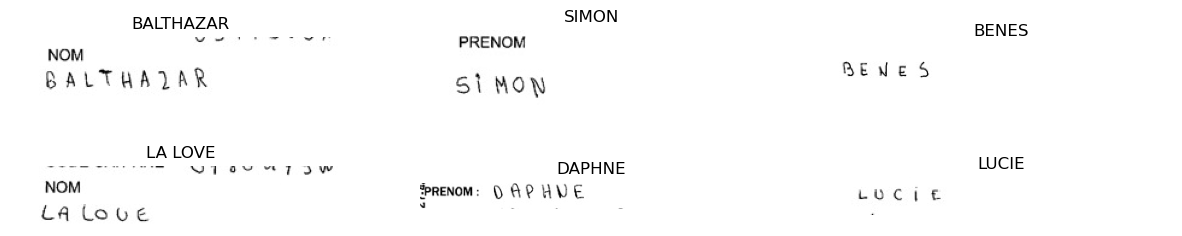

In [54]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [3]:
# Display data overview
print(train.head())
print(valid.head())
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

          FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE
              FILENAME    IDENTITY
0  VALIDATION_0001.jpg       BILEL
1  VALIDATION_0002.jpg  LAUMIONIER
2  VALIDATION_0003.jpg         LEA
3  VALIDATION_0004.jpg   JEAN-ROCH
4  VALIDATION_0005.jpg        RUPP
Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [4]:
# Remove rows with missing 'IDENTITY' and 'UNREADABLE' labels
train.dropna(inplace=True)
valid.dropna(inplace=True)
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [5]:
# Convert labels to uppercase
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

# Data Preprocessing

In [6]:
# Data Preprocessing
def preprocess(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256]) * 255
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

def load_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = preprocess(image) / 255.0
    return image

def load_data(df, size, data_path):
    x_data = []
    with ThreadPoolExecutor() as executor:
        img_paths = [os.path.join(data_path, fname) for fname in df['FILENAME'][:size]]
        images = list(executor.map(load_image, img_paths))
    
    for img in images:
        if img is not None:
            x_data.append(img)
    
    return np.array(x_data).reshape(-1, 256, 64, 1)

In [7]:
# Load and preprocess images
train_size = 30000
valid_size = 3000
train_x = load_data(train, train_size, 'train_v2/train/')
valid_x = load_data(valid, valid_size, 'validation_v2/validation/')

In [8]:
# Convert labels to numerical format
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64

def label_to_num(label):
    return np.array([alphabets.find(ch) for ch in label])

def num_to_label(num):
    return ''.join([alphabets[ch] for ch in num if ch != -1])

In [9]:
def prepare_labels(df, size):
    # Reset the index to ensure it is continuous
    df = df.reset_index(drop=True)
    
    # Ensure size does not exceed the length of the DataFrame
    if size > len(df):
        size = len(df)
        print(f"Size adjusted to match DataFrame length: {size}")

    y_data = np.ones([size, max_str_len]) * -1
    label_len = np.zeros([size, 1])
    input_len = np.ones([size, 1]) * (num_of_timestamps - 2)
    output = np.zeros([size])
    
    for i in range(size):
        try:
            label = df.loc[i, 'IDENTITY']
            label_len[i] = len(label)
            y_data[i, :len(label)] = label_to_num(label)
        except KeyError as e:
            print(f"KeyError at index {i}: {e}")
    
    return y_data, label_len, input_len, output

# Prepare labels for training and validation
train_y, train_label_len, train_input_len, train_output = prepare_labels(train, train_size)
valid_y, valid_label_len, valid_input_len, valid_output = prepare_labels(valid, valid_size)

In [76]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 64, 32)  320         ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 64, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Model Building

In [10]:
input_data = Input(shape=(256, 64, 1), name='input')

In [11]:
# Convolutional layers
inner = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2))(inner)

inner = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2))(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2))(inner)
inner = Dropout(0.3)(inner)

# Reshape and dense layers
inner = Reshape(target_shape=(64, 1024))(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal')(inner)

# RNN layers
inner = Bidirectional(LSTM(256, return_sequences=True))(inner)
inner = Bidirectional(LSTM(256, return_sequences=True))(inner)

# Output layer
inner = Dense(num_of_characters, kernel_initializer='he_normal')(inner)
y_pred = Activation('softmax')(inner)

In [104]:
# Define CTC loss
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [13]:
# Compile model
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))

# Model Training

In [14]:
# Train Model
history = model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
    epochs=50,
    batch_size=128
)

Epoch 1/50
235/235 [==============================] - 1614s 7s/step - loss: 24.6364 - val_loss: 20.6070
Epoch 2/50
235/235 [==============================] - 1557s 7s/step - loss: 20.1553 - val_loss: 20.0589
Epoch 3/50
235/235 [==============================] - 1576s 7s/step - loss: 19.7954 - val_loss: 19.6807
Epoch 4/50
235/235 [==============================] - 1576s 7s/step - loss: 19.4084 - val_loss: 19.3386
Epoch 5/50
235/235 [==============================] - 1560s 7s/step - loss: 18.7069 - val_loss: 18.3078
Epoch 6/50
235/235 [==============================] - 1544s 7s/step - loss: 17.5058 - val_loss: 17.2178
Epoch 7/50
235/235 [==============================] - 1577s 7s/step - loss: 15.9461 - val_loss: 16.1784
Epoch 8/50
235/235 [==============================] - 1553s 7s/step - loss: 13.9204 - val_loss: 14.3637
Epoch 9/50
235/235 [==============================] - 1555s 7s/step - loss: 11.8310 - val_loss: 12.3609
Epoch 10/50
235/235 [==============================] - 1547s 7s/

# Plot Training History

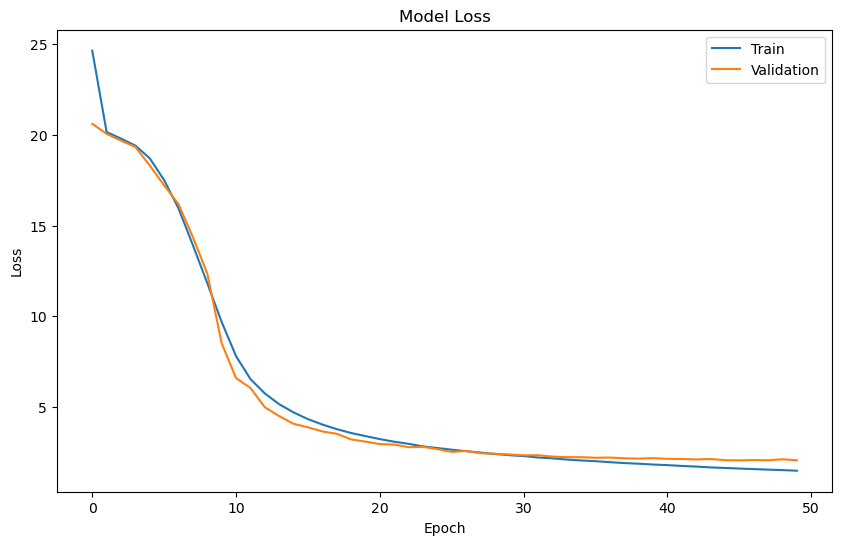

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

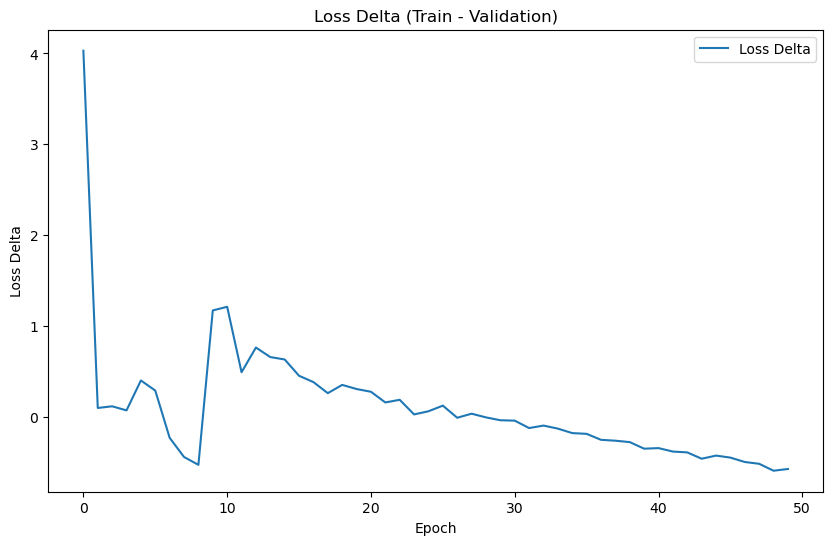

In [164]:
plt.figure(figsize=(10, 6))
loss_delta = np.array(history.history['loss']) - np.array(history.history['val_loss'])
plt.plot(loss_delta)
plt.title('Loss Delta (Train - Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss Delta')
plt.legend(['Loss Delta'])
plt.show()

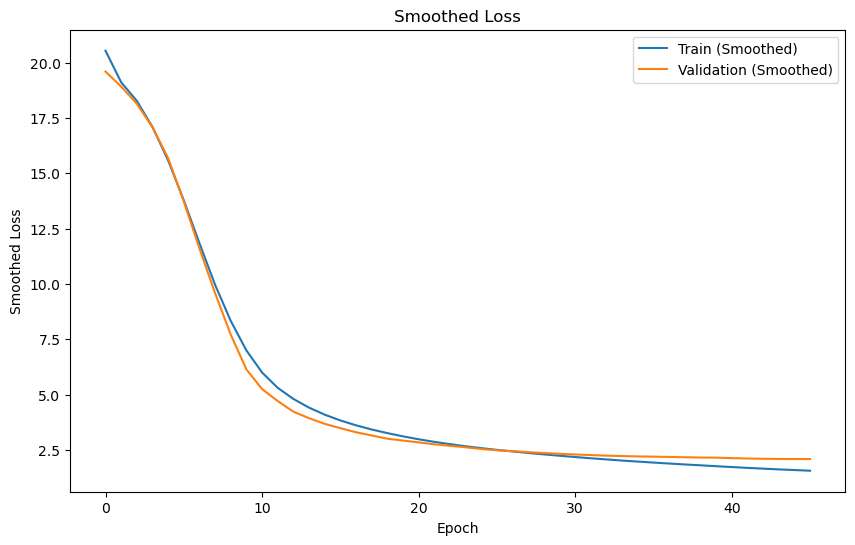

In [165]:
plt.figure(figsize=(10, 6))
smoothed_loss = np.convolve(history.history['loss'], np.ones(5)/5, mode='valid')
smoothed_val_loss = np.convolve(history.history['val_loss'], np.ones(5)/5, mode='valid')
plt.plot(smoothed_loss)
plt.plot(smoothed_val_loss)
plt.title('Smoothed Loss')
plt.xlabel('Epoch')
plt.ylabel('Smoothed Loss')
plt.legend(['Train (Smoothed)', 'Validation (Smoothed)'])
plt.show()

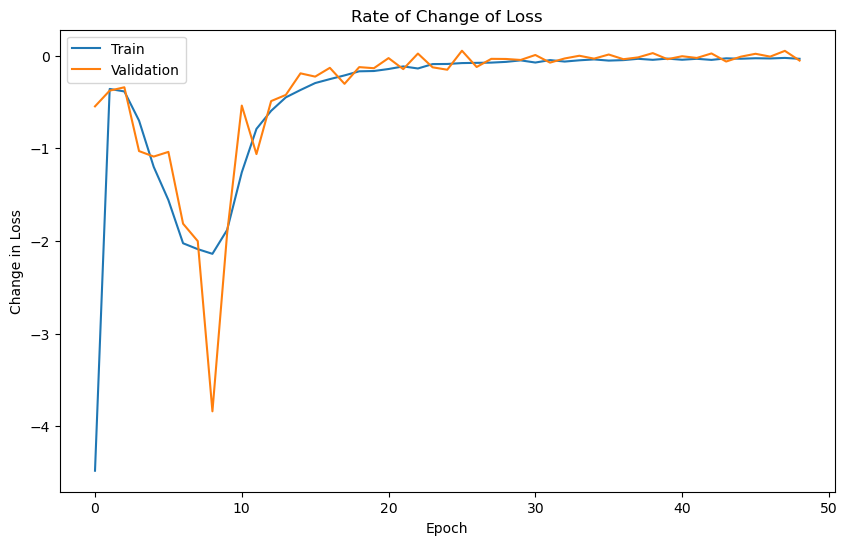

In [169]:
plt.figure(figsize=(10, 6))
loss_change_rate = np.diff(history.history['loss'])
val_loss_change_rate = np.diff(history.history['val_loss'])
plt.plot(loss_change_rate)
plt.plot(val_loss_change_rate)
plt.title('Rate of Change of Loss')
plt.xlabel('Epoch')
plt.ylabel('Change in Loss')
plt.legend(['Train', 'Validation'])
plt.show()